# Solution for the second science case

In [1]:
#########################################
# Author: Eduardo Alberto Duarte Lacerda
# E-mail: dhubax@gmail.com
#########################################

# needed Python imports
# imports for data retrieve
import lsdb
import splusdata
from dask.distributed import Client
# imports for plot and calculation
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt

# auxiliar functions and variables

# https://github.com/splus-collab/splus_filters for S-PLUS filters information
splus_bands = [
    'u', 'J0378', 'J0395', 'J0410', 'J0430', 
    'g', 'J0515', 'r', 'J0660', 'i', 'J0861', 'z',
]
# pivot wavelenght of S-PLUS filters 
splut_bands_pivot_wavelenghts = [
    3533.28, 3773.16, 3940.7, 4094.93, 
    4292.11, 4758.49, 5133.13, 6251.83, 
    6613.88, 7670.61, 8607.25, 8941.48
]

## S-PLUS Catalogs choice

In [2]:
# search for the full S-PLUS DR4/dual mode catalog
dr4dual_search = splusdata.get_hipscats('dr4/dual')

# Print all catalogs found with the pattern above
print(f'dr4/dual search: {dr4dual_search}')

# select the first catalog found
dr4dual_hipscat, dr4dual_margin_cache_hipscat = dr4dual_search[0]

# Search for the DR4 Star Galaxy Quasar VAC
'''
QSO/star/galaxy classification VAC: 
    https://splus.cloud/documentation/DR4?QSO/star/galaxy_classification
'''
dr4sqg_search = splusdata.get_hipscats('dr4/sqg')
# Print all catalogs found with the pattern above
print(f'dr4/sqg search: {dr4sqg_search}')
# select the first catalog found
dr4sqg_hipscat, dr4sqg_margin_cache_hipscat = dr4sqg_search[0]

# Create the columns list to retrieve only necessaries columns
'''/
We use here choose the magnitudes from 'auto' apperture mode.

Read mode about:
     https://splus.cloud/documentation/DR4?Photometry
'''
columns = ['ID', 'Field', 'RA', 'DEC', 'A', 'ISOarea']
apperture = 'auto'
bands = ['g', 'r', 'i' ,'J0660']
columns += [f'{b}_{apperture}' for b in bands] 
columns += [f's2n_{b}_{apperture}' for b in bands]

# filters 
SN_min = 5
filters = [(f's2n_{b}_{apperture}', '>', SN_min) for b in bands]
filters += [(f's2n_{b}_{apperture}', '!=', 99) for b in bands]
filters += [(f'{b}_{apperture}', '>', 14) for b in bands]
filters += [(f'{b}_{apperture}', '<', 22) for b in bands]

dr4/dual search: [['https://splus.cloud/HIPS/catalogs/dr4/dual/', 'https://splus.cloud/HIPS/catalogs/dr4/dual_2arcsec/']]
dr4/sqg search: [['https://splus.cloud/HIPS/catalogs/dr4_vacs/sqg/sqg/', 'https://splus.cloud/HIPS/catalogs/dr4_vacs/sqg/sqg_2arcsec/']]


## Read and crossmatch catalogs using LSDB

### Start Dask client

In [3]:
# Start a Dask client for the parallel process used by lsdb
max_cpu = 8
max_mem = '6GB'
client = Client(n_workers=max_cpu, memory_limit=max_mem)
client

<Client: 'tcp://127.0.0.1:46271' processes=8 threads=16, memory=44.70 GiB>

### Read and crossmatch catalogs

In [4]:
# Read more about the need of the margin cache server at:
#      https://lsdb.readthedocs.io/en/stable/tutorials/margins.html    
dr4dual_margin = lsdb.read_hipscat(dr4dual_margin_cache_hipscat)
dr4sqg_margin = lsdb.read_hipscat(dr4sqg_margin_cache_hipscat)

# Read DR4 dual HiPSCAT
dr4dual = lsdb.read_hipscat(
    dr4dual_hipscat,
    margin_cache=dr4dual_margin,
    # Read more about the available columns at:
    #      https://splus.cloud/documentation/DR4?Schemas,_tables_and_columns
    columns=columns,
    filters=filters,
)

# Read DR4 QSO/star/galaxy classification VAC HiPSCAT
# Here we filter only objects where the galaxy probability
# is greater than 80%
dr4sqg = lsdb.read_hipscat(
    dr4sqg_hipscat,
    margin_cache=dr4sqg_margin,
    filters=[('PROB_GAL', '>', 0.98)],
)

# Do the crossmatch of both catalogs. 
identity_radius = 1  # arcsec
dr4dualsqg_crosmatch = dr4dual.crossmatch(dr4sqg, suffixes=['_dr4', '_sqg'], radius_arcsec=identity_radius)


/home/lacerda/.pyenv/versions/sab/lib/python3.12/site-packages/hipscat/io/file_io/file_io.py:320: UserWarning: point_map.fits file written in RING ordering, due to https://github.com/astronomy-commons/hipscat/issues/271. Converting to NESTED.
  warnings.warn(


## Search for objects using the crossmatch result table

In [5]:
# Let's get the resultant table using a cone search:
cone_center_coord = (158.875, -27.25) # RA and DEC in degrees
cone_center_coord = (154, -25) # RA and DEC in degrees
cone_center_coord = (54.6209, -35.4507) # RA and DEC in degrees
cone_radius = 1.5*3600 # arcsec
objects_table = dr4dualsqg_crosmatch.cone_search(ra=cone_center_coord[0], dec=cone_center_coord[1], radius_arcsec=cone_radius).compute()

###  Spatial distribution plot

Text(0.5, 0, 'DEC')

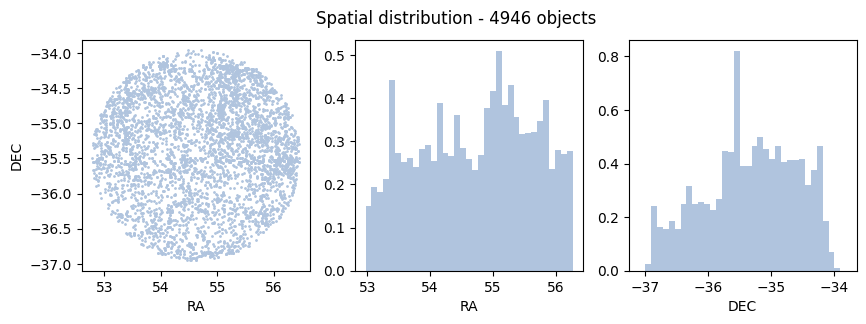

In [6]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3)
f.set_size_inches(10, 3)
N = len(objects_table)
f.suptitle(f'Spatial distribution - {N} objects')
ra = objects_table['RA_dr4']
dec = objects_table['DEC_dr4']
x = cone_radius/3600
ra_range = cone_center_coord[0]+np.array([-1.1*x, 1.1*x])
dec_range = cone_center_coord[1]+np.array([-1.1*x, 1.1*x])
ax1.scatter(ra, dec, s=1, c='lightsteelblue')
ax1.set_xlabel('RA')
ax1.set_ylabel('DEC')
ax2.hist(ra, bins=35, range=ra_range, density=True, color='lightsteelblue', histtype='stepfilled')
ax2.set_xlabel('RA')
ax3.hist(dec, bins=35, range=dec_range, density=True, color='lightsteelblue', histtype='stepfilled')
ax3.set_xlabel('DEC')

### Galaxies CMD plot (coloured by J0660 mag)

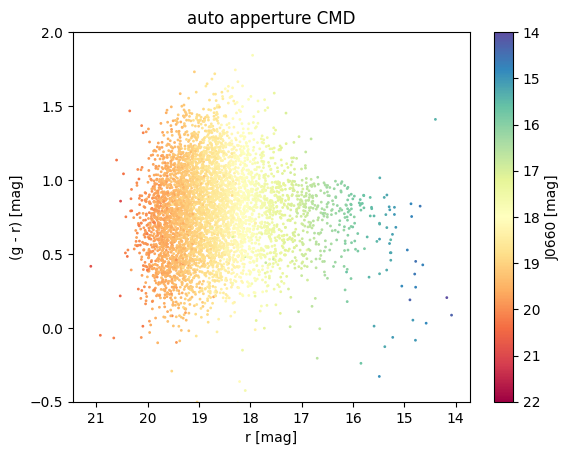

In [7]:
x = objects_table[f'r_{apperture}_dr4']
y = objects_table[f'g_{apperture}_dr4'] - objects_table[f'r_{apperture}_dr4']
z = objects_table[f'J0660_{apperture}_dr4']

f, ax = plt.subplots()
im = ax.scatter(x, y, c=z, s=1, cmap='Spectral_r', vmin=14, vmax=22)
ax.set_title(f'{apperture} apperture CMD')
cax = plt.colorbar(im, ax=ax)
cax.ax.set_ylabel('J0660 [mag]')
cax.ax.invert_yaxis()
ax.set_xlabel(f'r [mag]')
ax.set_ylabel(f'(g - r) [mag]')
ax.set_ylim(-0.5, 2)
ax.invert_xaxis()

### Find a big galaxy among the sources above

We can use photometry to search for a big galaxy among all the sources found in the crossmatch. In special we will search for the biggest *ISOarea* values and use the *A* parameter to *estimate* a size to plot a thumbnail of the source using [splusdata](https://github.com/Schwarzam/splusdata). This procedure will help us to create an IFS-like cube using [S-Cubes](https://github.com/elacerda/s-cubes).

In [8]:
conn = splusdata.Core()

splus.cloud username:  dhubax
splus.cloud password:  ········


0 SPLUS-s28s34 55.04056625865023 -35.61345430143036 1093.6952619390054


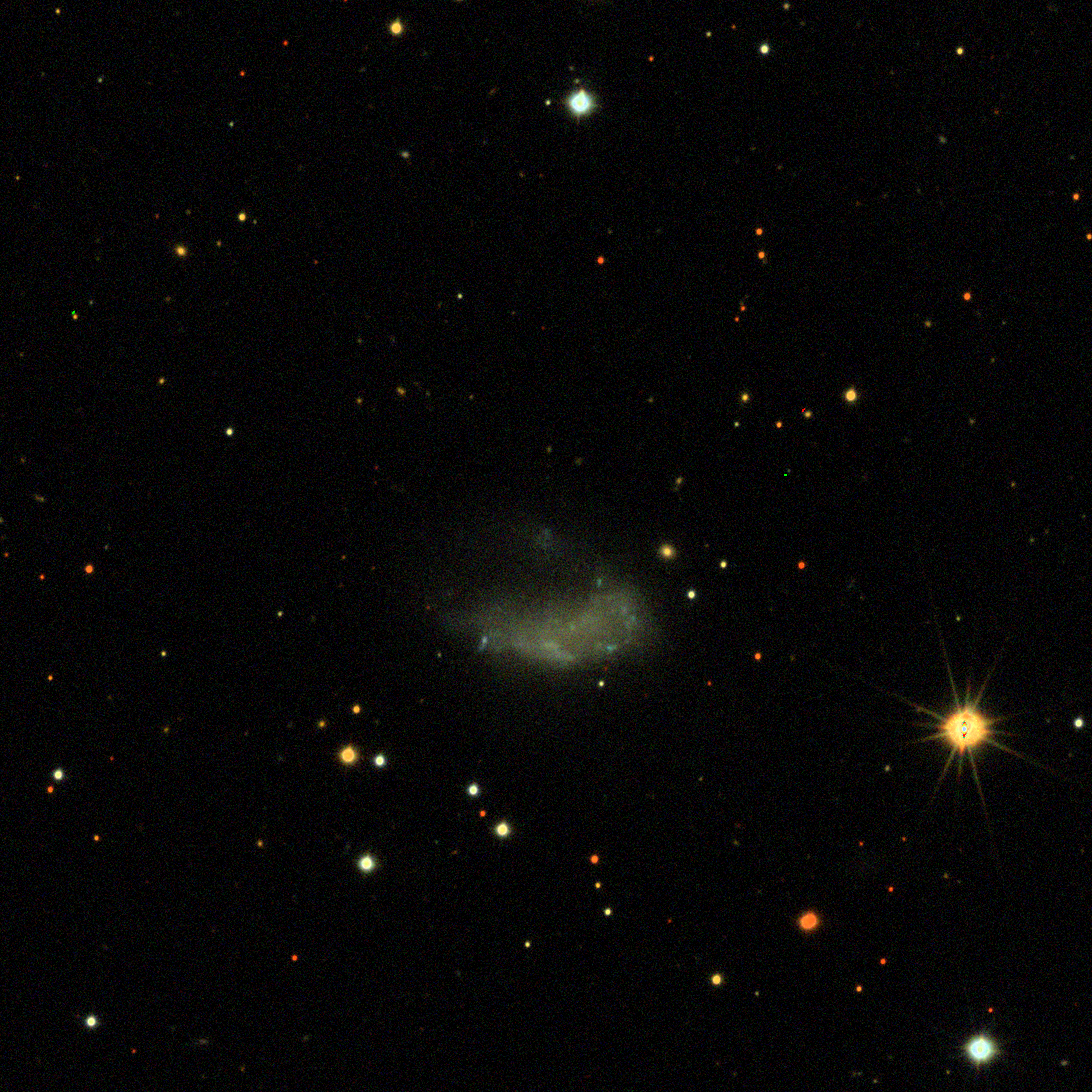

1 SPLUS-s28s34 55.02575830452312 -35.62414316168909 742.3055053434589


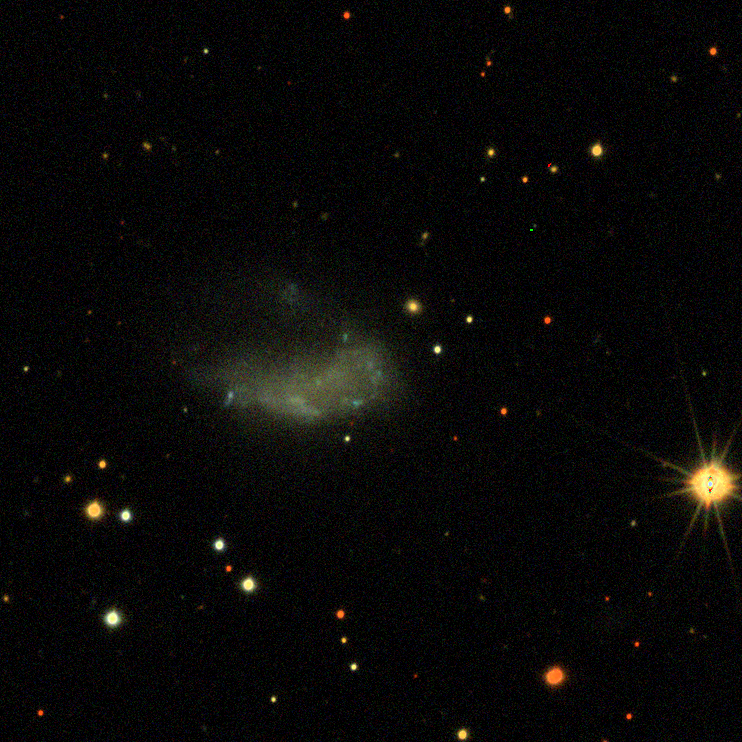

2 SPLUS-s27s33 53.223671898042355 -35.140083846775006 374.924929135225


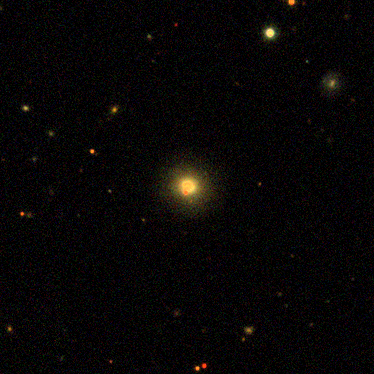

3 SPLUS-s27s35 55.70830982984947 -35.13259501183931 403.9546678012067


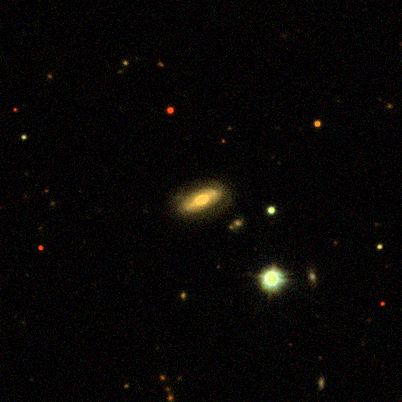

4 SPLUS-s28s34 55.210031192706275 -35.748453653902075 427.6281188834797


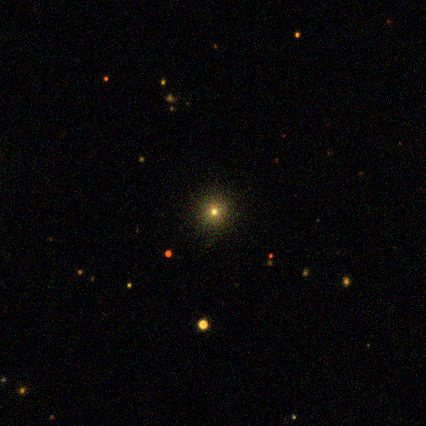

5 SPLUS-s28s34 54.182652086425826 -36.26086891519245 667.1707196669145


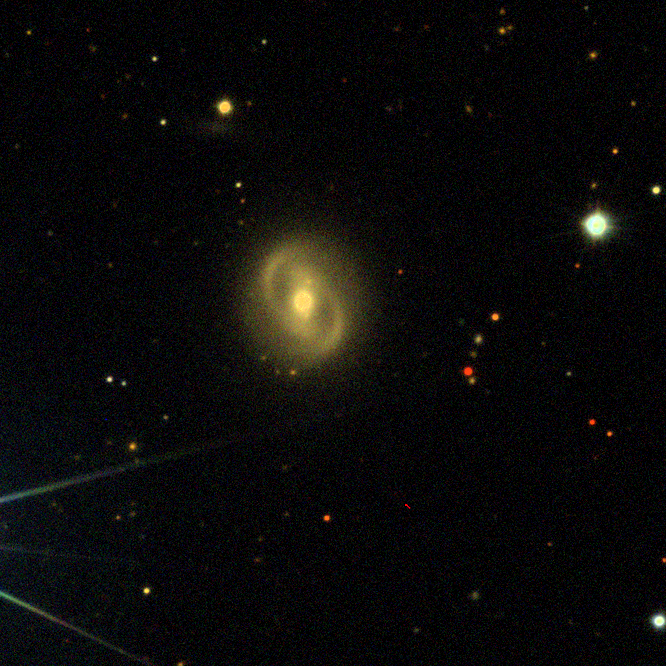

6 SPLUS-s27s35 55.02851582128841 -34.55799908897163 503.590792756189


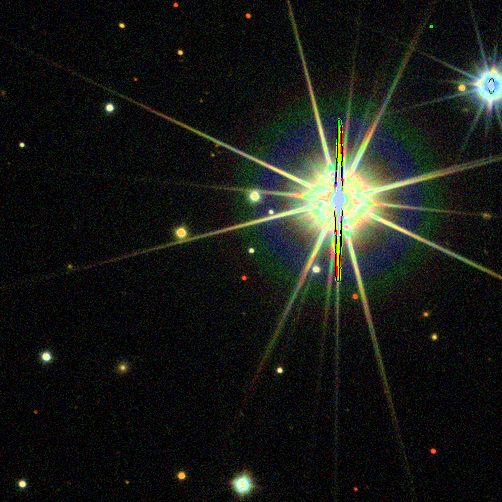

7 SPLUS-s28s33 53.24185616644257 -35.529717239158636 379.08942438662046


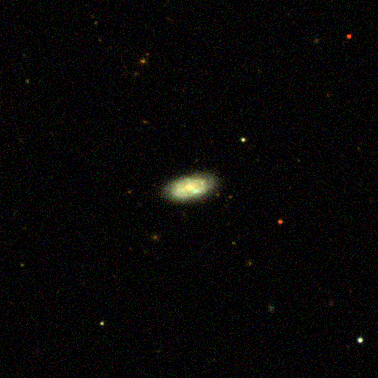

8 SPLUS-s28s33 53.303042781603345 -36.01735402044927 481.8282327191396


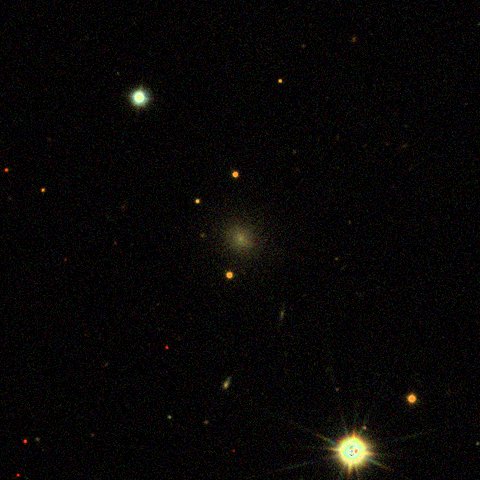

9 SPLUS-s28s34 54.19430128825739 -36.251453010655034 663.0773639137094


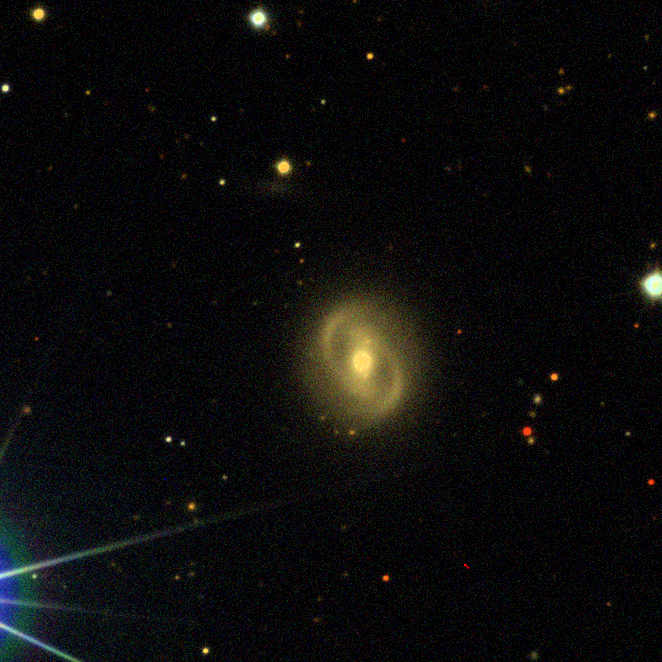

In [9]:
N_sources_to_print = 10
# Sort objects_table by ISOarea value and extract a table with the 
# N_sources_to_print first sources. Feel free to inspect as much 
# sources you want.
df = objects_table.sort_values(by='ISOarea_dr4', ascending=False).head(N_sources_to_print)
sources_thumbs = []
for i, row in enumerate(df.itertuples()):
    ra = row.RA_dr4
    dec = row.DEC_dr4

    # guess source size to create a inspect thumbnail
    A_arcsec = row.A_dr4*3600
    A_pix = A_arcsec/0.55 
    guess_size_pix = 30*A_pix
    
    print(i, row.Field_dr4, ra, dec, guess_size_pix)

    # try to display the thumbnail
    try:
        img = conn.lupton_rgb(ra, dec, guess_size_pix, 'I', 'R', 'G')
        img = img.transpose(Image.FLIP_TOP_BOTTOM)
        display(img)
        sources_thumbs.append(img)
    except:
        pass

RA: 53.223671898042355 
DEC: -35.140083846775006 
FIELD: SPLUS-s27s33 
GUESS SIZE: 374 pixels


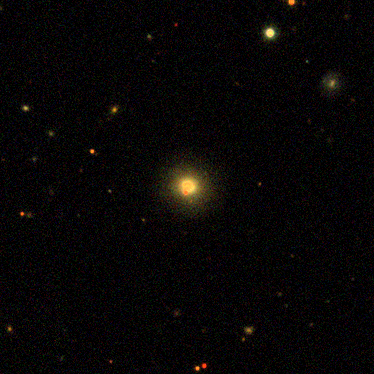

In [10]:
### Let's choose source index = 2
obj_i = 2
obj = df.iloc[obj_i]
pixsize_arcsec = 0.55
guess_scube_size_pix = int(30*obj.A_dr4*3600/pixsize_arcsec)
print('RA:', obj.RA_dr4, '\nDEC:', obj.DEC_dr4, '\nFIELD:', obj.Field_dr4, '\nGUESS SIZE:', guess_scube_size_pix, 'pixels')
display(sources_thumbs[obj_i])